In [219]:
from sklearn.tree import DecisionTreeClassifier
from lib.utils import load_raw,load_psd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.nn.functional import relu,one_hot

In [220]:
raw = load_raw(2)
df = load_psd(2)

In [221]:
eeg = raw.get_data(picks='EEG')[0]

In [222]:
X = eeg.reshape(-1,5000)
y = pd.Categorical(df['label']).codes
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).reshape(-1,1).long()

In [223]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y)
# if True:
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)

In [228]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3)
        self.mp1 = nn.MaxPool1d(kernel_size=2)
        self.c2 = nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3)
        self.mp2 = nn.MaxPool1d(kernel_size=2)

    def forward(self,x):
        x = self.c1(x)
        x = self.mp1(x)
        x = self.c2(x)
        x = self.mp2(x)
        return x
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

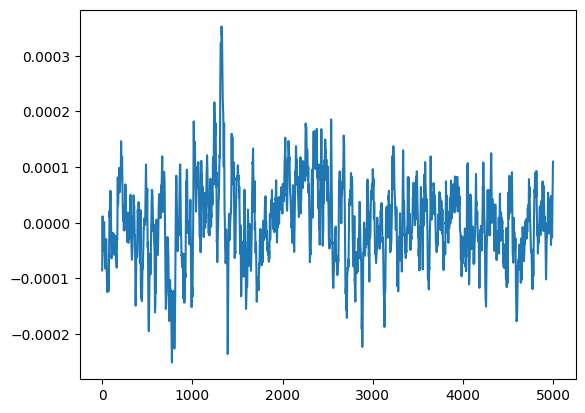

In [236]:
plt.plot(X_train[0])

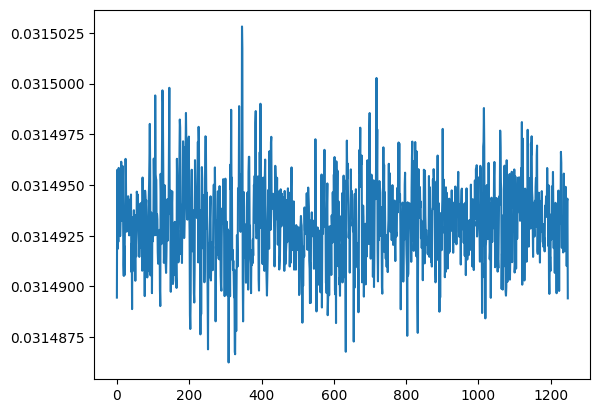

In [238]:
plt.plot(model(X_train[0:2].reshape(-1,1,5000))[0].detach().squeeze())

In [159]:
y_train_one_hot = one_hot(y_train,num_classes=3).reshape(-1,3).float()
y_test_one_hot = one_hot(y_test,num_classes=3).reshape(-1,3).float()

In [160]:
train_losses= []
test_losses = []

In [161]:
X_train = X_train.cuda()
y_train_one_hot = y_train_one_hot.cuda()
X_test = X_test.cuda()
y_test_one_hot = y_test_one_hot.cuda()

In [162]:
for epoch in range(100):
    logits = model(X_train)
    loss = criterion(logits,y_train_one_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    train_losses.append(loss.item())
    test_logits = model(X_test)
    test_loss = criterion(test_logits,y_test_one_hot)
    test_losses.append(test_loss.item())

tensor(1.1032, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0764, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0516, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0281, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0055, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9838, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9631, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9439, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9267, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9120, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9001, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8913, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8856, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8828, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8823, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8836, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8861, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8890, device='cuda:0', grad_fn=<DivBack

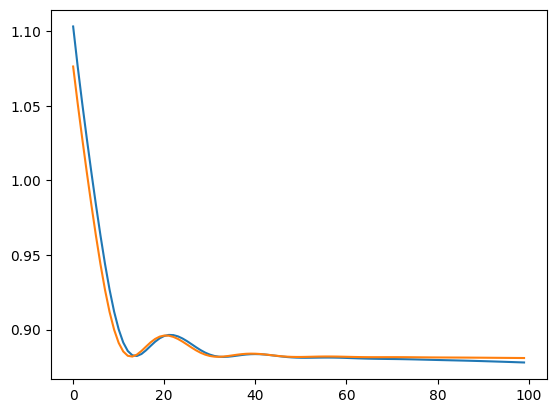

In [163]:
plt.plot(train_losses)
plt.plot(test_losses)

In [146]:
y_pred_logits = model(X_test)
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)

In [149]:
y_test = y_test.numpy().squeeze()

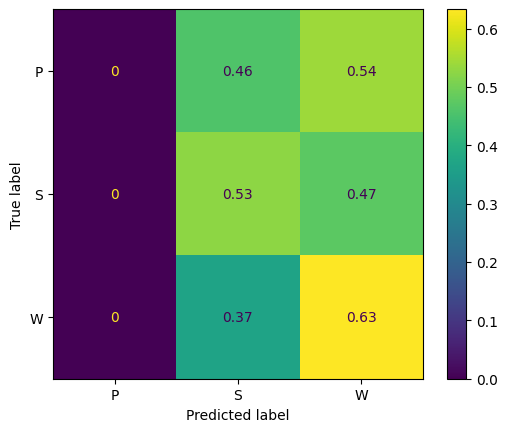

In [151]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred.cpu().numpy(),normalize='true'),display_labels=['P','S','W'])
cm.plot()